In [1]:
from sentence_transformers import SentenceTransformer, util

In [2]:
!pip install gradio

In [56]:
!wget -c https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz

--2025-06-14 12:11:28--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.10, 13.227.219.33, 13.227.219.70, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272365870 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ar.300.vec.gz’

cc.ar.300.vec.gz    100%[===================>]   1.18G  7.30MB/s    in 2m 37s  

2025-06-14 12:14:06 (7.75 MB/s) - ‘cc.ar.300.vec.gz’ saved [1272365870/1272365870]



In [3]:
!pip install wordcloud

In [4]:
!pip install arabic-reshaper python-bidi

In [5]:
!pip install gensim

In [6]:
import requests
import re
import pandas as pd
import gradio as gr
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

In [7]:
# --- Normalize Function ---
def normalize_arabic(text):
    text = re.sub("[ًٌٍَُِّْـ]", "", text)  # remove diacritics
    text = re.sub("[“”،۔…؛]", "", text)    # remove punctuation
    return text.strip()


In [8]:
# Load Quran data
url = "https://cdn.jsdelivr.net/npm/quran-json@3.1.2/dist/quran.json"
response = requests.get(url)
quran_data = response.json()


In [9]:
# --- Build DataFrame ---
verses = []
for surah in quran_data:
    for verse in surah['verses']:
        verses.append({
            "surah_id": surah["id"],
            "surah_name": surah["name"],
            "verse_id": verse["id"],
            "text": verse["text"],
            "cleaned": normalize_arabic(verse["text"])
        })

df = pd.DataFrame(verses)

In [10]:
# --- TF-IDF + Clustering ---
vectorizer_tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer_tfidf.fit_transform(df["cleaned"])
kmeans = KMeans(n_clusters=5, random_state=42)
df["cluster"] = kmeans.fit_predict(X_tfidf)

In [11]:
# Extract and flatten into rows
rows = []
for surah in quran_data:
    surah_number = surah['id']
    surah_name = surah['name']
    for ayah in surah['verses']:
        rows.append({
            'surah': surah_number,
            'surah_name': surah_name,
            'ayah': ayah['id'],
            'text': ayah['text'],

        })

# Create DataFrame
df = pd.DataFrame(rows)
df.head()

,surah,surah_name,ayah,text
0,1,الفاتحة,1,بِسۡمِ ٱللَّهِ ٱلرَّحۡمَٰنِ ٱلرَّحِيمِ
1,1,الفاتحة,2,ٱلۡحَمۡدُ لِلَّهِ رَبِّ ٱلۡعَٰلَمِينَ
2,1,الفاتحة,3,ٱلرَّحۡمَٰنِ ٱلرَّحِيمِ
3,1,الفاتحة,4,مَٰلِكِ يَوۡمِ ٱلدِّينِ
4,1,الفاتحة,5,إِيَّاكَ نَعۡبُدُ وَإِيَّاكَ نَسۡتَعِينُ


In [12]:
print("Total Ayahs:", df.shape[0])
print("Columns:", df.columns.tolist())
df.sample(3)

Total Ayahs: 6236
Columns: ['surah', 'surah_name', 'ayah', 'text']


,surah,surah_name,ayah,text
3440,30,الروم,32,مِنَ ٱلَّذِينَ فَرَّقُواْ دِينَهُمۡ وَكَانُواْ...
1491,11,هود,19,ٱلَّذِينَ يَصُدُّونَ عَن سَبِيلِ ٱللَّهِ وَيَب...
1885,15,الحجر,84,فَمَآ أَغۡنَىٰ عَنۡهُم مَّا كَانُواْ يَكۡسِبُونَ


In [13]:
df.tail()

,surah,surah_name,ayah,text
6231,114,الناس,2,مَلِكِ ٱلنَّاسِ
6232,114,الناس,3,إِلَٰهِ ٱلنَّاسِ
6233,114,الناس,4,مِن شَرِّ ٱلۡوَسۡوَاسِ ٱلۡخَنَّاسِ
6234,114,الناس,5,ٱلَّذِي يُوَسۡوِسُ فِي صُدُورِ ٱلنَّاسِ
6235,114,الناس,6,مِنَ ٱلۡجِنَّةِ وَٱلنَّاسِ


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6236 entries, 0 to 6235
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   surah       6236 non-null   int64 
 1   surah_name  6236 non-null   object
 2   ayah        6236 non-null   int64 
 3   text        6236 non-null   object
dtypes: int64(2), object(2)
memory usage: 195.0+ KB


In [15]:
# EDA summary
import pandas as pd

df = pd.DataFrame(verses)
print("Total Verses:", len(df))
print("Average Words per Verse:", df["cleaned"].apply(lambda x: len(x.split())).mean())
print("Max Words in a Verse:", df["cleaned"].apply(lambda x: len(x.split())).max())
print("Min Words in a Verse:", df["cleaned"].apply(lambda x: len(x.split())).min())
print("Total Surahs:", df['surah_id'].nunique())
print("Surahs with Most Verses:")
print(df['surah_name'].value_counts().head(10))


Total Verses: 6236
Average Words per Verse: 12.416452854393842
Max Words in a Verse: 128
Min Words in a Verse: 1
Total Surahs: 114
Surahs with Most Verses:
surah_name
البقرة      286
الشعراء     227
الأعراف     206
آل عمران    200
الصافات     182
النساء      176
الأنعام     165
طه          135
التوبة      129
النحل       128
Name: count, dtype: int64


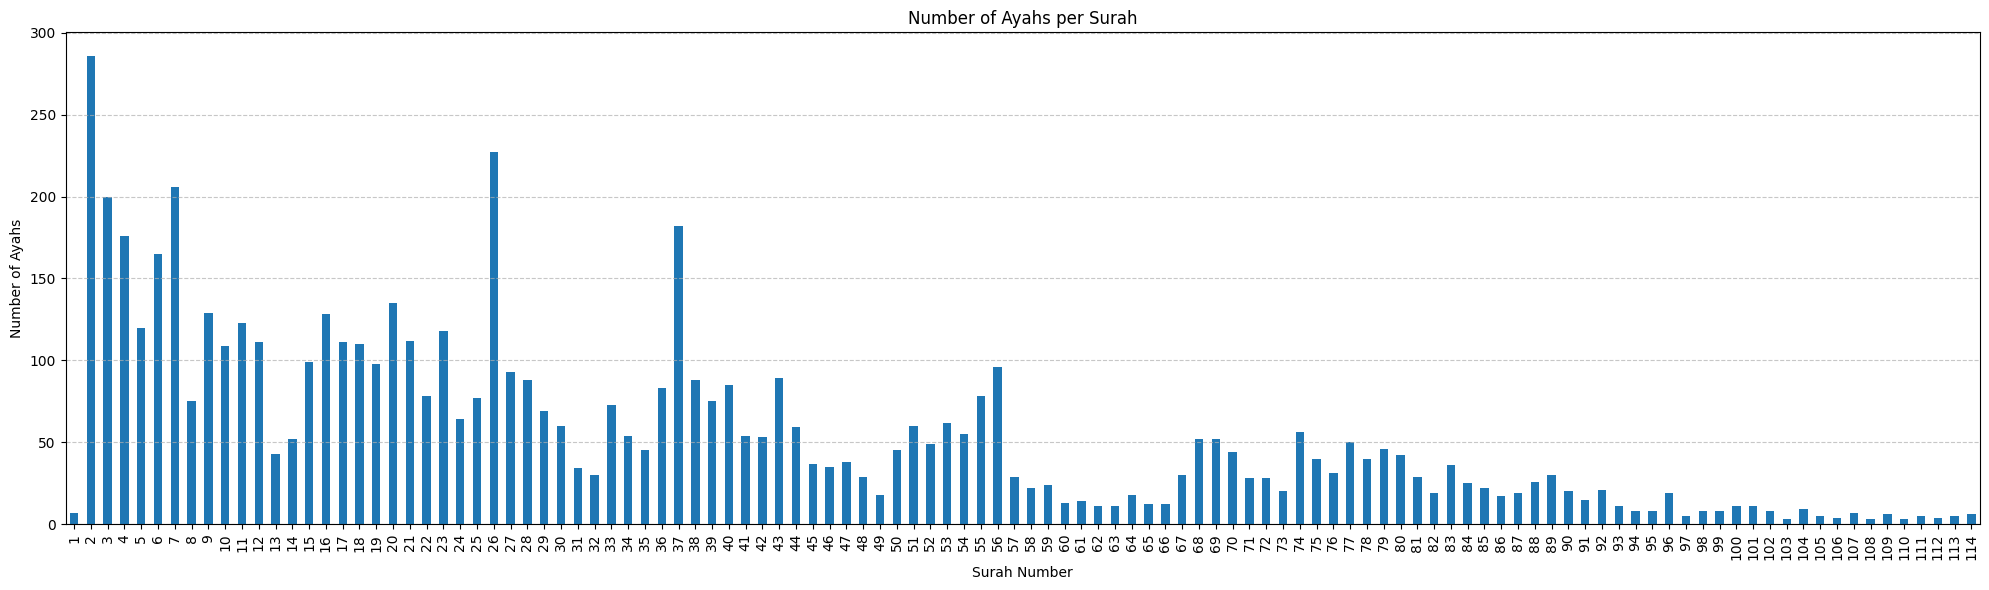

In [19]:
import matplotlib.pyplot as plt

# Group by 'surah_id' to count how many verses (ayahs) each Surah has
ayahs_per_surah = df.groupby('surah_id')['verse_id'].count().sort_index()

# Plot the bar chart
plt.figure(figsize=(20, 6))
ayahs_per_surah.plot(kind='bar')
plt.title('Number of Ayahs per Surah')
plt.xlabel('Surah Number')
plt.ylabel('Number of Ayahs')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [20]:
# logest and shortest ayat
df['ayah_length'] = df['text'].str.len()

longest = df.loc[df['ayah_length'].idxmax()]
shortest = df.loc[df['ayah_length'].idxmin()]

print("Longest Ayah:")
print(longest)

print("\nShortest Ayah:")
print(shortest)

Longest Ayah:
surah_id                                                       2
surah_name                                                البقرة
verse_id                                                     282
text           يَـٰٓأَيُّهَا ٱلَّذِينَ ءَامَنُوٓاْ إِذَا تَدَ...
cleaned        يٰٓأيها ٱلذين ءامنوٓا إذا تداينتم بديۡن إلىٰٓ ...
ayah_length                                                 1189
Name: 288, dtype: object

Shortest Ayah:
surah_id       20
surah_name     طه
verse_id        1
text           طه
cleaned        طه
ayah_length     2
Name: 2348, dtype: object


In [21]:
df['word_count'] = df['cleaned'].apply(lambda x: len(x.split()))
df['char_count'] = df['cleaned'].apply(len)

print(" Word Count Stats:")
print(df['word_count'].describe())

print("\n Character Count Stats:")
print(df['char_count'].describe())

 Word Count Stats:
count    6236.000000
mean       12.416453
std         9.417633
min         1.000000
25%         6.000000
50%        10.000000
75%        16.000000
max       128.000000
Name: word_count, dtype: float64

 Character Count Stats:
count    6236.000000
mean       74.359686
std        56.960409
min         2.000000
25%        32.000000
50%        61.000000
75%        98.000000
max       793.000000
Name: char_count, dtype: float64


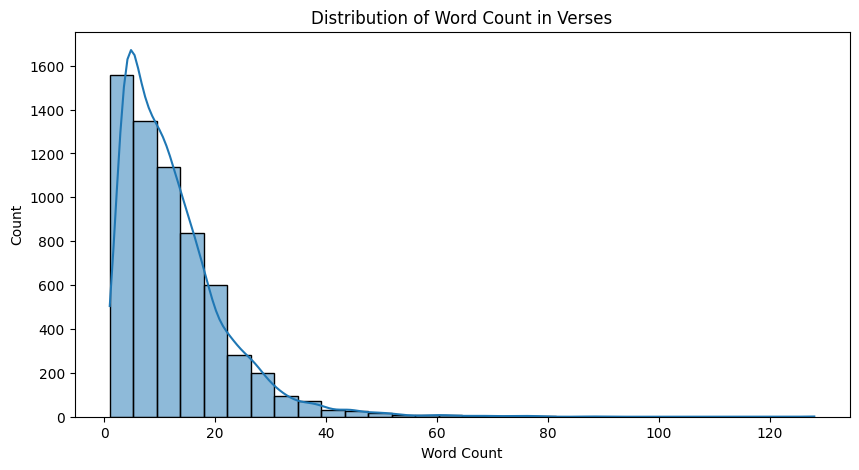

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], bins=30, kde=True)
plt.title('Distribution of Word Count in Verses')
plt.xlabel("Word Count")
plt.show()


In [23]:
from collections import Counter

all_words = " ".join(df["cleaned"]).split()
word_freq = Counter(all_words)
most_common = word_freq.most_common(20)

for word, freq in most_common:
    print(f"{word}: {freq}")


من: 2090
ٱلله: 1896
في: 1099
ما: 872
إن: 862
ٱلذين: 810
لا: 747
ولا: 604
أن: 580
إلا: 562
وما: 507
منۡ: 498
قال: 407
علىٰ: 347
ثم: 340
كان: 323
ذٰلك: 265
أوۡ: 263
ومن: 258
بما: 253


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1649 (\N{ARABIC LETTER ALEF WASLA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1761 (\N{ARABIC SMALL HIGH DOTLESS HEAD OF KHAH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


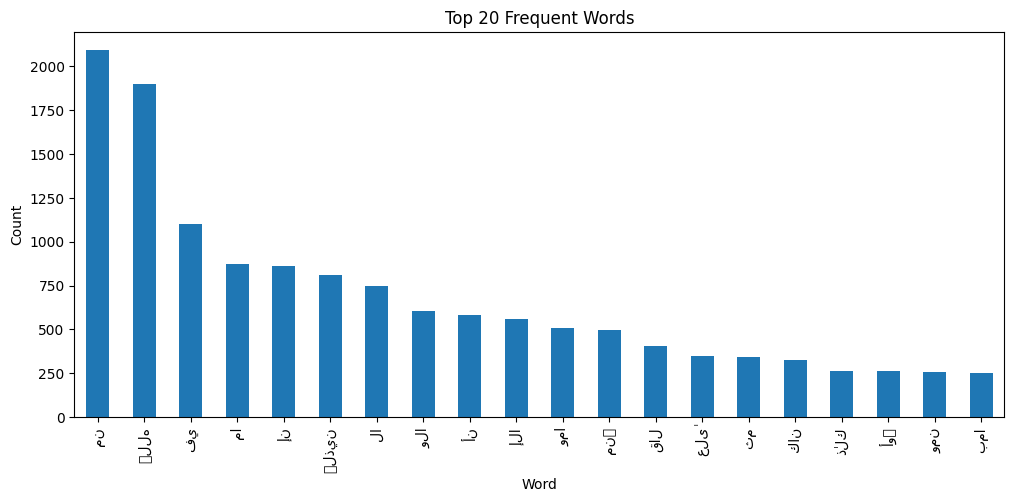

In [24]:
pd.DataFrame(most_common, columns=['Word', 'Frequency']).plot(kind='bar', x='Word', y='Frequency', legend=False, figsize=(12, 5), title='Top 20 Frequent Words')
plt.ylabel("Count")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


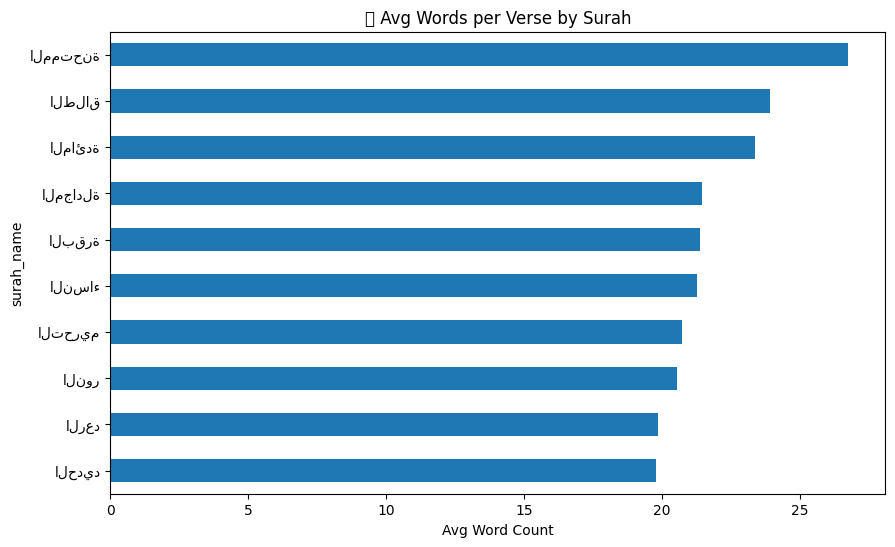

In [25]:
avg_words_per_surah = df.groupby("surah_name")["word_count"].mean().sort_values(ascending=False)
avg_words_per_surah.head(10).plot(kind="barh", figsize=(10, 6), title="📏 Avg Words per Verse by Surah")
plt.xlabel("Avg Word Count")
plt.gca().invert_yaxis()
plt.show()

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Vectorize
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df["cleaned"])

In [27]:
# Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df["cluster"] = kmeans.fit_predict(X)

In [28]:
# Cluster stats
print(df["cluster"].value_counts().sort_index())

cluster
0    1080
1    1107
2    2324
3    1073
4     652
Name: count, dtype: int64


In [29]:
from collections import defaultdict

# Group identical Arabic ayahs
clusters = defaultdict(list)

for index, row in df.iterrows():
    text = row['text']
    reference = f"{row['surah_id']}:{row['verse_id']}"
    clusters[text].append(reference)

# Filter only repeated ayahs (more than once)
identical_clusters = {text: refs for text, refs in clusters.items() if len(refs) > 1}

# Show some of the repeated ayahs
for text, refs in list(identical_clusters.items())[:]:
    print(f"Text: {text}\nRepeated at: {refs}\n")

Text: الٓمٓ
Repeated at: ['2:1', '3:1', '29:1', '30:1', '31:1', '32:1']

Text: أُوْلَـٰٓئِكَ عَلَىٰ هُدٗى مِّن رَّبِّهِمۡۖ وَأُوْلَـٰٓئِكَ هُمُ ٱلۡمُفۡلِحُونَ
Repeated at: ['2:5', '31:5']

Text: يَٰبَنِيٓ إِسۡرَـٰٓءِيلَ ٱذۡكُرُواْ نِعۡمَتِيَ ٱلَّتِيٓ أَنۡعَمۡتُ عَلَيۡكُمۡ وَأَنِّي فَضَّلۡتُكُمۡ عَلَى ٱلۡعَٰلَمِينَ
Repeated at: ['2:47', '2:122']

Text: تِلۡكَ أُمَّةٞ قَدۡ خَلَتۡۖ لَهَا مَا كَسَبَتۡ وَلَكُم مَّا كَسَبۡتُمۡۖ وَلَا تُسۡـَٔلُونَ عَمَّا كَانُواْ يَعۡمَلُونَ
Repeated at: ['2:134', '2:141']

Text: خَٰلِدِينَ فِيهَا لَا يُخَفَّفُ عَنۡهُمُ ٱلۡعَذَابُ وَلَا هُمۡ يُنظَرُونَ
Repeated at: ['2:162', '3:88']

Text: وَٱلَّذِينَ كَفَرُواْ وَكَذَّبُواْ بِـَٔايَٰتِنَآ أُوْلَـٰٓئِكَ أَصۡحَٰبُ ٱلۡجَحِيمِ
Repeated at: ['5:10', '5:86']

Text: وَمَا تَأۡتِيهِم مِّنۡ ءَايَةٖ مِّنۡ ءَايَٰتِ رَبِّهِمۡ إِلَّا كَانُواْ عَنۡهَا مُعۡرِضِينَ
Repeated at: ['6:4', '36:46']

Text: وَلَقَدِ ٱسۡتُهۡزِئَ بِرُسُلٖ مِّن قَبۡلِكَ فَحَاقَ بِٱلَّذِينَ سَخِرُواْ مِنۡهُم مَّا كَانُواْ بِهِۦ يَسۡتَهۡزِءُونَ
Repeat

In [30]:
# Display clusters of identical ayahs
for i, (text, references) in enumerate(identical_clusters.items(), 1):
    print(f"\n🔁 Cluster {i}")
    print(f"🕋 Arabic Text: {text}")
    print(f"📍 Locations: {', '.join(references)}")
    print(f"🔁 Repeated: {len(references)} times")


🔁 Cluster 1
🕋 Arabic Text: الٓمٓ
📍 Locations: 2:1, 3:1, 29:1, 30:1, 31:1, 32:1
🔁 Repeated: 6 times

🔁 Cluster 2
🕋 Arabic Text: أُوْلَـٰٓئِكَ عَلَىٰ هُدٗى مِّن رَّبِّهِمۡۖ وَأُوْلَـٰٓئِكَ هُمُ ٱلۡمُفۡلِحُونَ
📍 Locations: 2:5, 31:5
🔁 Repeated: 2 times

🔁 Cluster 3
🕋 Arabic Text: يَٰبَنِيٓ إِسۡرَـٰٓءِيلَ ٱذۡكُرُواْ نِعۡمَتِيَ ٱلَّتِيٓ أَنۡعَمۡتُ عَلَيۡكُمۡ وَأَنِّي فَضَّلۡتُكُمۡ عَلَى ٱلۡعَٰلَمِينَ
📍 Locations: 2:47, 2:122
🔁 Repeated: 2 times

🔁 Cluster 4
🕋 Arabic Text: تِلۡكَ أُمَّةٞ قَدۡ خَلَتۡۖ لَهَا مَا كَسَبَتۡ وَلَكُم مَّا كَسَبۡتُمۡۖ وَلَا تُسۡـَٔلُونَ عَمَّا كَانُواْ يَعۡمَلُونَ
📍 Locations: 2:134, 2:141
🔁 Repeated: 2 times

🔁 Cluster 5
🕋 Arabic Text: خَٰلِدِينَ فِيهَا لَا يُخَفَّفُ عَنۡهُمُ ٱلۡعَذَابُ وَلَا هُمۡ يُنظَرُونَ
📍 Locations: 2:162, 3:88
🔁 Repeated: 2 times

🔁 Cluster 6
🕋 Arabic Text: وَٱلَّذِينَ كَفَرُواْ وَكَذَّبُواْ بِـَٔايَٰتِنَآ أُوْلَـٰٓئِكَ أَصۡحَٰبُ ٱلۡجَحِيمِ
📍 Locations: 5:10, 5:86
🔁 Repeated: 2 times

🔁 Cluster 7
🕋 Arabic Text: وَمَا تَأۡتِيهِم مِّنۡ ءَايَة

In [31]:
# Create a list of rows to export
export_data = []

for text, references in identical_clusters.items():
    for ref in references:
        surah, ayah = ref.split(':')
        export_data.append({
            'text': text,
            'surah': surah,
            'ayah': ayah,
            'count': len(references)
        })

# Save to CSV
df_export = pd.DataFrame(export_data)
df_export.to_csv('identical_ayah_clusters.csv', index=False, encoding='utf-8-sig')
print("✅ Saved to 'identical_ayah_clusters.csv'")


✅ Saved to 'identical_ayah_clusters.csv'


In [34]:
def check_ayah_repetition(input_ayah, clusters_dict):
    """
    Given an Arabic ayah and a dictionary of identical clusters,
    print all Surah and Ayah positions where that exact ayah occurs.
    """
    if input_ayah in clusters_dict:
        occurrences = clusters_dict[input_ayah]
        print(f"✅ Ayah found {len(occurrences)} time(s) in the Quran.\n")
        for occ in occurrences:
            # Split the string if it's like "55:13"
            try:
                surah, ayah = occ.split(":")
                print(f"🔸 Surah {surah}, Ayah {ayah}")
            except ValueError:
                print(f"⚠️ Unexpected format: {occ}")
    else:
        print("❌ Ayah not found or is unique.")


In [35]:
user_input = "إِذَا تُتۡلَىٰ عَلَيۡهِ ءَايَٰتُنَا قَالَ أَسَٰطِيرُ ٱلۡأَوَّلِينَ"
check_ayah_repetition(user_input, identical_clusters)


✅ Ayah found 2 time(s) in the Quran.

🔸 Surah 68, Ayah 15
🔸 Surah 83, Ayah 13


In [36]:
# Sample ayaat per cluster
for cluster in sorted(df["cluster"].unique()):
    print(f"\nCluster {cluster}:")
    samples = df[df["cluster"] == cluster].head(2)
    for _, row in samples.iterrows():
        print(f"{row['surah_name']} ({row['verse_id']}): {row['text']}")


Cluster 0:
الفاتحة (2): ٱلۡحَمۡدُ لِلَّهِ رَبِّ ٱلۡعَٰلَمِينَ
الفاتحة (6): ٱهۡدِنَا ٱلصِّرَٰطَ ٱلۡمُسۡتَقِيمَ

Cluster 1:
البقرة (9): يُخَٰدِعُونَ ٱللَّهَ وَٱلَّذِينَ ءَامَنُواْ وَمَا يَخۡدَعُونَ إِلَّآ أَنفُسَهُمۡ وَمَا يَشۡعُرُونَ
البقرة (19): أَوۡ كَصَيِّبٖ مِّنَ ٱلسَّمَآءِ فِيهِ ظُلُمَٰتٞ وَرَعۡدٞ وَبَرۡقٞ يَجۡعَلُونَ أَصَٰبِعَهُمۡ فِيٓ ءَاذَانِهِم مِّنَ ٱلصَّوَٰعِقِ حَذَرَ ٱلۡمَوۡتِۚ وَٱللَّهُ مُحِيطُۢ بِٱلۡكَٰفِرِينَ

Cluster 2:
الفاتحة (3): ٱلرَّحۡمَٰنِ ٱلرَّحِيمِ
الفاتحة (4): مَٰلِكِ يَوۡمِ ٱلدِّينِ

Cluster 3:
الفاتحة (1): بِسۡمِ ٱللَّهِ ٱلرَّحۡمَٰنِ ٱلرَّحِيمِ
البقرة (15): ٱللَّهُ يَسۡتَهۡزِئُ بِهِمۡ وَيَمُدُّهُمۡ فِي طُغۡيَٰنِهِمۡ يَعۡمَهُونَ

Cluster 4:
الفاتحة (7): صِرَٰطَ ٱلَّذِينَ أَنۡعَمۡتَ عَلَيۡهِمۡ غَيۡرِ ٱلۡمَغۡضُوبِ عَلَيۡهِمۡ وَلَا ٱلضَّآلِّينَ
البقرة (3): ٱلَّذِينَ يُؤۡمِنُونَ بِٱلۡغَيۡبِ وَيُقِيمُونَ ٱلصَّلَوٰةَ وَمِمَّا رَزَقۡنَٰهُمۡ يُنفِقُونَ


<ipython-input-37-2634677407>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="cluster", palette="viridis")


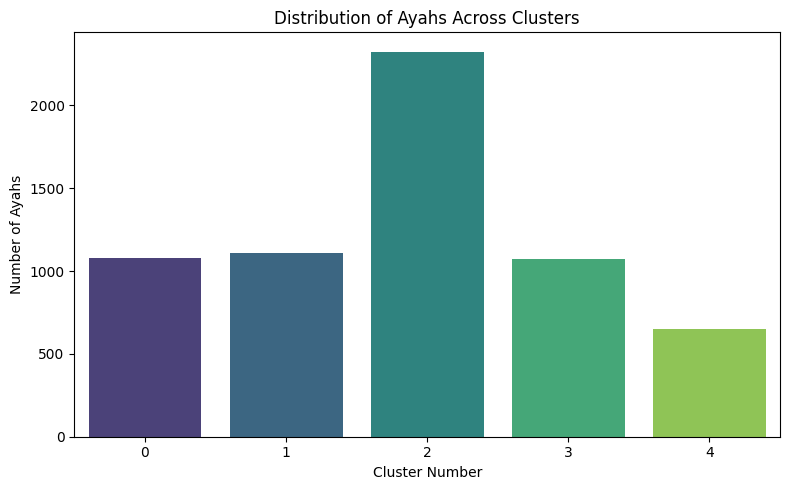

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="cluster", palette="viridis")
plt.title("Distribution of Ayahs Across Clusters")
plt.xlabel("Cluster Number")
plt.ylabel("Number of Ayahs")
plt.tight_layout()
plt.show()


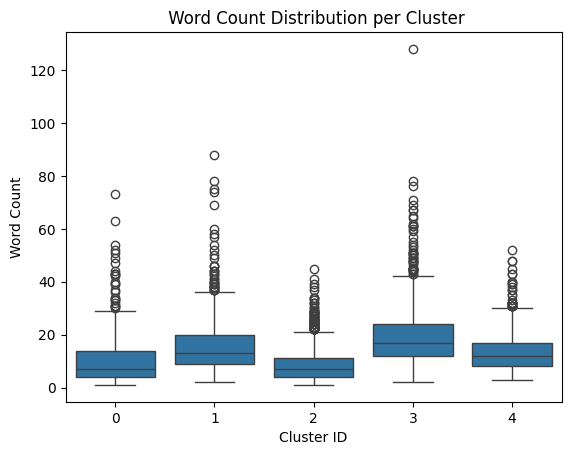

In [38]:
sns.boxplot(data=df, x='cluster', y='word_count')
plt.title(" Word Count Distribution per Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Word Count")
plt.show()

In [39]:
# Input verse (raw and cleaned)
input_ayah = "فَبِأَيِّ ءَالَآءِ رَبِّكُمَا تُكَذِّبَانِ"
#input_ayah = "وَكَذَّبُواْ بِـَٔايَٰتِنَآ أُوْلَـٰٓئِكَ أَصۡحَٰبُ ٱلنَّارِۖ هُمۡ فِيهَا خَٰلِدُونَ"
#input_ayah = "أُوْلَـٰٓئِكَ عَلَىٰ هُدٗى مِّن رَّبِّهِمۡۖ وَأُوْلَـٰٓئِكَ هُمُ"
#input_ayah = "عَذَابٞ"

input_cleaned = normalize_arabic(input_ayah)


In [40]:
# Vectorize text using character-level n-grams (to capture short matches)
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 4))
corpus = [input_cleaned] + [v["cleaned"] for v in verses]
X = vectorizer.fit_transform(corpus)


In [41]:
# Compute cosine similarity
cos_sim = cosine_similarity(X[0:1], X[1:]).flatten()


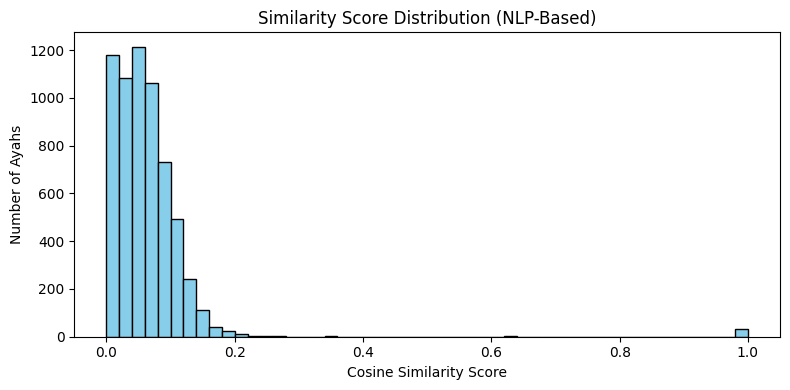

In [42]:
plt.figure(figsize=(8, 4))
plt.hist(cos_sim, bins=50, color="skyblue", edgecolor="black")
plt.title("Similarity Score Distribution (NLP-Based)")
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Number of Ayahs")
plt.tight_layout()
plt.show()


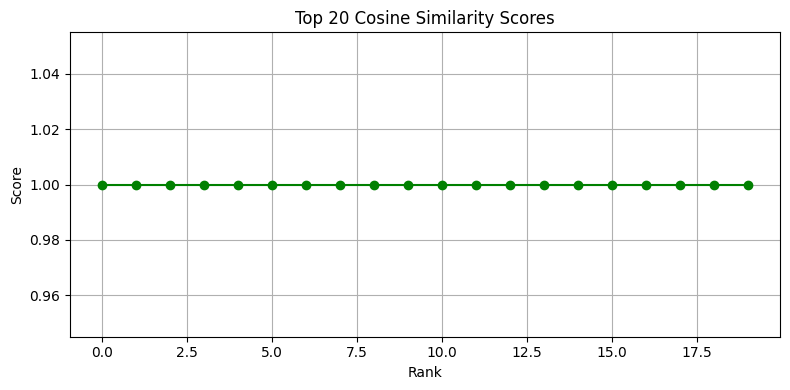

In [43]:
top_scores = sorted(cos_sim, reverse=True)[:20]

plt.figure(figsize=(8, 4))
plt.plot(top_scores, marker='o', color='green')
plt.title("Top 20 Cosine Similarity Scores")
plt.ylabel("Score")
plt.xlabel("Rank")
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
# Get top exact/similar matches (threshold e.g., > 0.7)
results = []
for i, score in enumerate(cos_sim):
    if score > 0.7:  # Adjust this threshold as needed
        results.append({
            "surah_id": verses[i]["surah_id"],
            "surah_name": verses[i]["surah_name"],
            "verse_id": verses[i]["verse_id"],
            "text": verses[i]["text"],
            "similarity_percent": round(score * 100, 2)
        })


In [45]:
# Sort by similarity
results = sorted(results, key=lambda x: -x["similarity_percent"])


In [46]:
# Display
print(f"Total similar Ayahs found: {len(results)}\n")
for r in results:
    print(f"{r['surah_name']} ({r['surah_id']}:{r['verse_id']}) — {r['similarity_percent']}%")
    print(r['text'])
    print("---")

Total similar Ayahs found: 31

الرحمن (55:13) — 100.0%
فَبِأَيِّ ءَالَآءِ رَبِّكُمَا تُكَذِّبَانِ
---
الرحمن (55:16) — 100.0%
فَبِأَيِّ ءَالَآءِ رَبِّكُمَا تُكَذِّبَانِ
---
الرحمن (55:18) — 100.0%
فَبِأَيِّ ءَالَآءِ رَبِّكُمَا تُكَذِّبَانِ
---
الرحمن (55:21) — 100.0%
فَبِأَيِّ ءَالَآءِ رَبِّكُمَا تُكَذِّبَانِ
---
الرحمن (55:23) — 100.0%
فَبِأَيِّ ءَالَآءِ رَبِّكُمَا تُكَذِّبَانِ
---
الرحمن (55:25) — 100.0%
فَبِأَيِّ ءَالَآءِ رَبِّكُمَا تُكَذِّبَانِ
---
الرحمن (55:28) — 100.0%
فَبِأَيِّ ءَالَآءِ رَبِّكُمَا تُكَذِّبَانِ
---
الرحمن (55:30) — 100.0%
فَبِأَيِّ ءَالَآءِ رَبِّكُمَا تُكَذِّبَانِ
---
الرحمن (55:32) — 100.0%
فَبِأَيِّ ءَالَآءِ رَبِّكُمَا تُكَذِّبَانِ
---
الرحمن (55:34) — 100.0%
فَبِأَيِّ ءَالَآءِ رَبِّكُمَا تُكَذِّبَانِ
---
الرحمن (55:36) — 100.0%
فَبِأَيِّ ءَالَآءِ رَبِّكُمَا تُكَذِّبَانِ
---
الرحمن (55:38) — 100.0%
فَبِأَيِّ ءَالَآءِ رَبِّكُمَا تُكَذِّبَانِ
---
الرحمن (55:40) — 100.0%
فَبِأَيِّ ءَالَآءِ رَبِّكُمَا تُكَذِّبَانِ
---
الرحمن (55:42) — 100.0%
فَبِأَيِّ

In [47]:
# Load pre-trained Arabic-supporting model model
model = SentenceTransformer('asafaya/bert-base-arabic')

# Encode all verses into embeddings
texts = [v["text"] for v in verses]
verse_embeddings = model.encode(texts, convert_to_numpy=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/334k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [48]:
texts
verse_embeddings

array([[-0.0851924 , -0.96937   , -1.0680565 , ...,  1.0797112 ,
        -0.6628885 ,  0.1431103 ],
       [ 0.05543445, -0.8646353 , -0.5784143 , ...,  1.4218231 ,
         0.01524752,  0.7565198 ],
       [ 0.0084599 , -0.7440364 , -1.3534341 , ...,  0.99320483,
        -0.4423068 ,  0.46426862],
       ...,
       [ 0.27630544, -1.119419  , -1.2273763 , ...,  1.0665379 ,
         0.11332882,  0.3959448 ],
       [ 0.14377202, -1.1141046 , -1.1595771 , ...,  1.8675144 ,
        -0.00559733,  0.3223263 ],
       [ 0.0054369 , -0.4066016 , -0.8506532 , ...,  1.3421388 ,
        -0.3558257 ,  0.31513876]], dtype=float32)

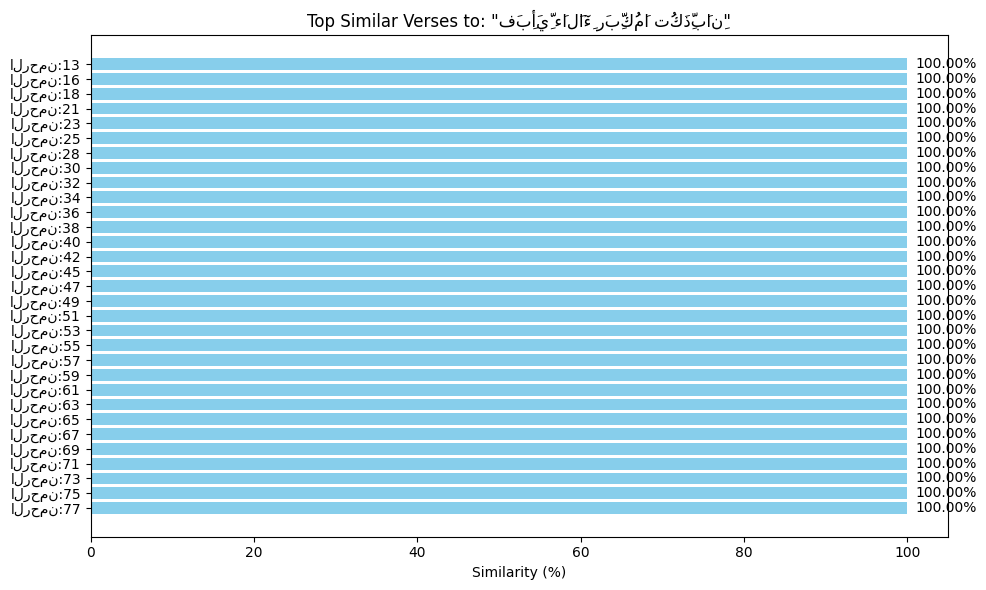

In [49]:
# Extract data for plotting
labels = [f"{r['surah_name']}:{r['verse_id']}" for r in results]
scores = [r['similarity_percent'] for r in results]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(labels, scores, color='skyblue')
plt.xlabel("Similarity (%)")
plt.title(f"Top Similar Verses to: \"{input_ayah}\"")
plt.gca().invert_yaxis()  # Highest on top

# Add score labels to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2,
             f'{width:.2f}%', va='center')

plt.tight_layout()
plt.show()

In [50]:
# Function to find top-N simentic verses
def find_similar_verses(input_text, top_n=5):
    input_embedding = model.encode([input_text], convert_to_numpy=True)
    similarities = cosine_similarity(input_embedding, verse_embeddings)[0]
    top_indices = np.argsort(-similarities)[:top_n]
    results = []
    for idx in top_indices:
        results.append({
            "surah_id": verses[idx]["surah_id"],
            "surah_name": verses[idx]["surah_name"],
            "verse_id": verses[idx]["verse_id"],
            "text": verses[idx]["text"],
            "similarity_percent": round(float(similarities[idx]) * 100, 2)
        })
    return results

In [51]:
def find_all_similar_verses(input_text, threshold=30.0):
    """
    Returns all verses with similarity above the given threshold (default 30%).
    Sorted from most similar to least.
    """
    input_embedding = model.encode([input_text], convert_to_numpy=True)
    similarities = cosine_similarity(input_embedding, verse_embeddings)[0]

    results = []
    for idx, score in enumerate(similarities):
        percent = float(score) * 100
        if percent >= threshold:  # filter if needed
            results.append({
                "surah_id": verses[idx]["surah_id"],
                "surah_name": verses[idx]["surah_name"],
                "verse_id": verses[idx]["verse_id"],
                "text": verses[idx]["text"],
                "similarity_percent": round(percent, 2)
            })

    # Sort all results by similarity, descending
    results.sort(key=lambda x: -x['similarity_percent'])
    return results

In [52]:
input_ayah = input("Insrt ayat :")
# results = find_similar_verses(input_ayah, top_n=5)
results = find_all_similar_verses(input_ayah, threshold=20.0)

# Display results
for r in results:
    print(f"{r['surah_name']} (Surah ID: {r['surah_id']}), Verse {r['verse_id']} | Similarity: {r['similarity_percent']}%")
    print(f"→ {r['text']}\n")

Streaming output truncated to the last 5000 lines.
→ ٱتۡلُ مَآ أُوحِيَ إِلَيۡكَ مِنَ ٱلۡكِتَٰبِ وَأَقِمِ ٱلصَّلَوٰةَۖ إِنَّ ٱلصَّلَوٰةَ تَنۡهَىٰ عَنِ ٱلۡفَحۡشَآءِ وَٱلۡمُنكَرِۗ وَلَذِكۡرُ ٱللَّهِ أَكۡبَرُۗ وَٱللَّهُ يَعۡلَمُ مَا تَصۡنَعُونَ

القلم (Surah ID: 68), Verse 38 | Similarity: 58.1%
→ إِنَّ لَكُمۡ فِيهِ لَمَا تَخَيَّرُونَ

البقرة (Surah ID: 2), Verse 109 | Similarity: 58.09%
→ وَدَّ كَثِيرٞ مِّنۡ أَهۡلِ ٱلۡكِتَٰبِ لَوۡ يَرُدُّونَكُم مِّنۢ بَعۡدِ إِيمَٰنِكُمۡ كُفَّارًا حَسَدٗا مِّنۡ عِندِ أَنفُسِهِم مِّنۢ بَعۡدِ مَا تَبَيَّنَ لَهُمُ ٱلۡحَقُّۖ فَٱعۡفُواْ وَٱصۡفَحُواْ حَتَّىٰ يَأۡتِيَ ٱللَّهُ بِأَمۡرِهِۦٓۗ إِنَّ ٱللَّهَ عَلَىٰ كُلِّ شَيۡءٖ قَدِيرٞ

يوسف (Surah ID: 12), Verse 110 | Similarity: 58.09%
→ حَتَّىٰٓ إِذَا ٱسۡتَيۡـَٔسَ ٱلرُّسُلُ وَظَنُّوٓاْ أَنَّهُمۡ قَدۡ كُذِبُواْ جَآءَهُمۡ نَصۡرُنَا فَنُجِّيَ مَن نَّشَآءُۖ وَلَا يُرَدُّ بَأۡسُنَا عَنِ ٱلۡقَوۡمِ ٱلۡمُجۡرِمِينَ

الأنفال (Surah ID: 8), Verse 53 | Similarity: 58.08%
→ ذَٰلِكَ بِأَنَّ ٱللَّهَ لَمۡ يَكُ مُغَيِّرٗا نِّعۡ

In [58]:
# --- NLP Similarity Function ---
def nlp_similarity(input_ayah):
    input_cleaned = normalize_arabic(input_ayah)
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 4))
    corpus = [input_cleaned] + df["cleaned"].tolist()
    X = vectorizer.fit_transform(corpus)
    cos_sim = cosine_similarity(X[0:1], X[1:]).flatten()

    results = []
    for i, score in enumerate(cos_sim):
        if score > 0.7:
            results.append({
                "surah_id": df.iloc[i]["surah_id"],
                "surah_name": df.iloc[i]["surah_name"],
                "verse_id": df.iloc[i]["verse_id"],
                "text": df.iloc[i]["text"],
                "similarity_percent": round(score * 100, 10)
            })

    if not results:
        return "No NLP-based similar ayahs found."

    output = f"### NLP-Based Similar Ayahs: {len(results)}\n\n"
    for r in results:
        output += f"**{r['surah_name']} ({r['surah_id']}:{r['verse_id']}) — {r['similarity_percent']}%**\n\n"
        output += f"{r['text']}\n\n---\n"
    return output

In [59]:
def cluster_similarity(input_ayah):
    input_cleaned = normalize_arabic(input_ayah)

    # Find input vector & cluster
    input_vec = vectorizer_tfidf.transform([input_cleaned])
    input_cluster = kmeans.predict(input_vec)[0]

    # Get verses in the same cluster
    cluster_df = df[df["cluster"] == input_cluster].copy()

    # Find only exact cleaned matches (excluding the input verse itself)
    exact_matches = cluster_df[cluster_df["cleaned"] == input_cleaned]

    if exact_matches.empty:
        return "No exact same ayahs found in this cluster."

    output = f"### Cluster-Based Exact Matches Found: {len(exact_matches)}\n\n"
    for _, row in exact_matches.iterrows():
        output += f"**{row['surah_name']} ({row['surah_id']}:{row['verse_id']})**\n\n"
        output += f"{row['text']}\n\n---\n"

    return output


In [60]:
# --- GUI Layout ---
with gr.Blocks() as demo:
    gr.Markdown("## 🕋 Quran Ayah Similarity Search")
    gr.Markdown("Enter an ayah to find similar ones using **NLP** and **Cluster-based** methods.")

    with gr.Row():
        input_text = gr.Textbox(label="Enter Arabic Ayah", placeholder="مثال: فَبِأَيِّ ءَالَآءِ رَبِّكُمَا تُكَذِّبَانِ")

    with gr.Row():
        with gr.Column():
            gr.Markdown("### 🔍 NLP Similarity Results")
            nlp_btn = gr.Button("Find NLP Similarities")
            nlp_output = gr.Markdown()

        with gr.Column():
            gr.Markdown("### 📊 Cluster Similarity Results")
            cluster_btn = gr.Button("Find Cluster Similarities")
            cluster_output = gr.Markdown()

    nlp_btn.click(nlp_similarity, inputs=input_text, outputs=nlp_output)
    cluster_btn.click(cluster_similarity, inputs=input_text, outputs=cluster_output)

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cee0f30a6b814975e4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
#input_ayah = "فَبِأَيِّ ءَالَآءِ رَبِّكُمَا تُكَذِّبَانِ"
#input_ayah = "وَكَذَّبُواْ بِـَٔايَٰتِنَآ أُوْلَـٰٓئِكَ أَصۡحَٰبُ ٱلنَّارِۖ هُمۡ فِيهَا خَٰلِدُونَ"
#input_ayah = "أُوْلَـٰٓئِكَ عَلَىٰ هُدٗى مِّن رَّبِّهِمۡۖ وَأُوْلَـٰٓئِكَ هُمُ ٱلۡمُفۡلِحُونَ"
#فَبِأَيِّ آلَاءِ رَبِّكَ تَتَمَارَىٰ
#إِنَّ ٱلَّذِينَ ءَامَنُواْ وَعَمِلُواْ ٱلصَّـٰلِحَـٰتِ